## Movie recommendation using matrix factorization - SURPRISE python package

### I. Theory behind matrix factorization methodology

**Dimensionality reduction using matrix factorization**

Our rating dataset can be represnted as a matrix of rows N and columns M, where N is the number of users and M is the number of movies. This matrix is filled with the ratings of users for each movie.

The idea behind matrix factorization of our rating table is to reduce its dimensionality. Right now we have thousands of movie's ratings for each user. We want to reduce this to fewer dimensions (say F) for each user which will still explain most of the ratings. This allow us to discover the most important latent features underlying the interactions between users and movies. This methodology helps in scaling the algorithm to big datasets and performs better than usual item based or user based CBF.

We reduce the dimensionality of our rating matrix R by factorizing it into two factors P and Q as shown below -  

\begin{equation*}
R =  P . Q^T
\end{equation*}

where,
 - **R** is our rating matrix of size (N, M)
 - **P** is our first factorized matrix of user feature of size (N, F)
 - **Q** is our second factorized matrix of item feature of size (N, F)
 - **F** is chosen such that $F < min(n,m)$


The above factorization looks very similar to the **truncated singular value decomposition (SVD)** problem were we factorize any matrix of size (N,M) into 3 factors U, S and V. Read more about SVD from its [Wiki page](https://en.wikipedia.org/wiki/Singular_value_decomposition).

**Truncated SVD**

\begin{equation*}
R \approx \hat{R} = U. \hat{S}. V^T
\end{equation*}

where,
 - **R** is a matrix of size (N,M)
 - $\hat{\textbf{R}}$ is an approximation matrix of R with the rank k
 - **U** is a matrix of size (N,k)
 - $\hat{\textbf{S}}$ is a diagonal matrix of size (k,k) - this is made up of top k **Singular Values** of matrix **R** 
 - **V** is a matrix of size (M,k)
 
In truncated SVD the approximation of $\textbf{R}$ with $\hat{\textbf{R}}$ is called Low Rank Matrix approximation. Again, read more about it on the wiki page. This is what we want to do for our rating matrix $\textbf{R}$ as well.  

However, SVD is only applicable if the original matrix R is full and does not have missing values. In our case its not true as our rating matrix is very sparse and has lots of missing values. We could try to impute these missing values with some base values (like global average or item level average etc.) and then factorize it. This will however, beat the purpose of rating prediction for missing ratings as now the factorized matrices will try to approximate these missing ratings as close to these base values. So we cannot use the SVD for our problem.

**FunkSVD : Matrix Factorization using SGD - Simon Funk's methodology from Netflix Competition**

A modified approach is to factorize the rating matrix by the method **highlighted by Simon Funk during the netflix prize competition**. Read about it on [his blog here](https://sifter.org/~simon/journal/20061211.html). He basically factorized the matrix by trying to approximate each user feature value and item feature value by reducing the error between the PREDICTED rating vs the KNOWN ratings (for non-missing ratings only). He used **stochastic gradient descent** approach to optimally solve for the values by minimizing the cost function.

So, if we factorize the ratings matrix R into P and Q matrices with reduced dimension K, then the predicted rating by user u for the movie i using the two factorized matrices will be - 

\begin{equation*}
\hat{r}_{ui} = p_u . q_i^T = \sum_{k=1}^{K} p_{uk} . q_{ik}^T
\end{equation*}

**Adding bias** to the predicted rating : To account for the fact that each user has some some bias in giving the ratings (some give higher ratings than most and some user give lower ratings), we introduce the bias terms in the predicted rating. A bias for rating $r_{ui}$ can be expressed as - 

\begin{equation*}
b_{ui} = \mu + b_i + b_u 
\end{equation*}

Here $\mu$ is the global average rating, $b_i$ is the item bias and $b_u$ is the user bias. For example, suppose that we want to estimate for user Joe’s rating of the movie Titanic. Now, say that the average rating over all movies, $\mu$ is 3.7 stars. Furthermore, Titanic is better than an average movie, so it tends to be rated 0.5 stars above the average ($b_i$). On the other hand, Joe is a critical user, who tends to rate 0.3 stars lower than the average ($b_u$). Thus, the estimate for Titanic’s rating by Joe would be 3.9 stars (3.7 + 0.5 - 0.3). Adding these bias terms to the predicted rating above changes the predicted rating to -

\begin{equation*}
\hat{r}_{ui} = \mu + b_i + b_u + p_u . q_i^T
\end{equation*}

The error between the predicted the actual rating will be -

\begin{equation*}
    e_{ui} = (r_{ui} - \hat{r}_{ui}) = (r_{ui} - \mu - b_i - b_u - p_u.q_i^T)
\end{equation*}

We can define the cost function for our optimising algo as the square of this error summed up over all the training ratings (non-missing ones) - 

\begin{equation*}
    \text{Cost Function C} = \sum_{r_{ui} \in R_{train}} (r_{ui} - \mu - b_i - b_u - p_u.q_i^T)^2
\end{equation*}

**Adding regularization** to our cost function : To avoid overfitting by the algorithms based on the training ratings we also add the regularization factors to our cost function. The revised cost function is now - 

\begin{equation*}
    \text{Cost Function C} = \sum_{r_{ui} \in R_{train}} (r_{ui} - \mu - b_i - b_u - p_u.q_i^T)^2 + \lambda . (b_u^2 + b_i^2 + ||p_u||^2 + ||q_i||^2)
\end{equation*}

where, $\lambda$ is the regularization factor.

Once we have the cost function we can use gradient descent process to minimize this cost iteratively and solve for the unknowns. The steps for this would be as follows -

 - Calculate the gradient formulas for the cost function wrt. each of the unknown factors. These gradient formula would be used to calculate the gradient value at each iteration and update each of these factors so as to reach a point of minimum cost. 
 - Randomly initialize the values of all unknown parameters before starting the itearion.
 - Iteratively, calculate the gradient of the cost function wrt each unknown factor
 - Update the unknown factors by moving them by a little step (a learning rate) in the negative direction of the gradient.
 - Update the cost function value with the new unknown factors values and then repeat the iterations till the cost value becomes below a certain value or stops changing much (stopping criteria for the iteration).

Without going into the detail the gradient formula calculations, the final formula for step by step update for each unknown factor is shown below. We can use this to calculate the updated values in each iteration. 

\begin{equation*}
b_u \leftarrow b_u + \gamma . (e_{ui} - \lambda.b_u) \\
b_i \leftarrow b_i + \gamma . (e_{ui} - \lambda.b_i) \\
p_u \leftarrow p_u + \gamma . (e_{ui}.q_i - \lambda.p_u) \\
q_i \leftarrow q_i + \gamma . (e_{ui}.p_u - \lambda.q_i)
\end{equation*}

where $\gamma$ is the learning rate (small step used in each iteration).


Further details of the methodology can be read in detail in the following reference materials -

 - [Simon's journal](https://sifter.org/~simon/journal/20061211.html)
 - [Paper by Yehuda Koren](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf)
 - [Paper by Arkadiusz Paterek](https://www.mimuw.edu.pl/~paterek/ap_kdd.pdf)
 - [Post by Albert Yeung for python implementation](http://www.albertauyeung.com/post/python-matrix-factorization/)
 
 
### II. Details of our exercise

In this exercise we will use the matrix factorization method to create a movie recommendation function.

We will test this methodology for Movielens dataset. You can get the latest datsets [here](https://grouplens.org/datasets/movielens/latest/). This dataset has 2500 movies and 862 user's movie ratings. The ratings table is ~260K. The datasets available for this exercise have the following two tables:

 - **movies**  : This dataset has the movieId and the name and details of all the movies in the database.
 - **ratings** : This dataset has the ratings given by each userId to the movieId they have seen.

We also have a larger version of the same dataset with ~27K movies and ~138K users with ~20M rows in ratings dataset.
 
**We will do the following exercises to explore the [surpise package](http://surpriselib.com/) in python:**

 1. **Test the SVD algorithm and try to find best parameters (learning rate & regularization factor) on small dataset**
 2. **Test the RMSE score from various algorithms - SVD, knnbasic, knnwithmeans, NMF (with and without bias) on small dataset**
 3. **Choose the best algorithm and test it on the large dataset and check the time taken for prediction**

In [1]:
####################################
# 1. import key libraries and datasets
####################################

import pandas as pd
import numpy as np
import time
import gc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.pairwise import cosine_similarity as cs
from surprise import SVD
from surprise import KNNWithMeans
from surprise import NMF
from surprise import KNNBasic
from surprise import accuracy
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

sns.set(style='darkgrid')
sns.set(font_scale=1.5)

# import datasets - small
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

# Get basic information about the datasets
print "Small dataset movies rows :", movies.shape[0], " and ratings rows :",ratings.shape[0]
print 'Unique movies in small dataset : ', movies['movieId'].nunique()
print 'Unique users in small ratings data : ', ratings['userId'].nunique()
print 'Unique movies in small ratings data : ', ratings['movieId'].nunique()

#reformat the rating dataset as per the surprise package requirement
ratings = ratings.rename(columns={'movieId':'itemId'})

Small dataset movies rows : 2500  and ratings rows : 264505
Unique movies in small dataset :  2500
Unique users in small ratings data :  862
Unique movies in small ratings data :  2500


In [2]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings.head()

,userId,itemId,rating,timestamp
0,12882,1,4.0,1147195252
1,12882,32,3.5,1147195307
2,12882,47,5.0,1147195343
3,12882,50,5.0,1147185499
4,12882,110,4.5,1147195239


### I. Test SVD algorithm and find best parameters - learning rate & regularization factor

In [4]:
####################################
# Use SVD algorithm from the Surprise package to get the predictions 
# we will also find the suitable prameters - learning rate and regilarization rate
# using the training dataset and then use the best parameters for the test set to get the rmse
####################################

st = time.time()

#define the rating scale for surprise reader and read the rating dataset 
rdr = Reader(rating_scale=(1,5))
rating_data = Dataset.load_from_df(ratings[['userId', 'itemId', 'rating']], rdr)

# sample random trainset and testset
# test set is made of 20% of the ratings.
trainset, testset = train_test_split(rating_data, test_size=.2, random_state=123)

#loop over various parameters to find the best RMSE within the trainset
test_temp = trainset.build_testset()
param_summ = pd.DataFrame(columns=['learning_rate', 'reg_parm', 'train_rmse'])

for lr in [0.004, 0.006, 0.008, 0.01, 0.012]:
    for reg in [0.03, 0.04, 0.05, 0.06, 0.07]:
        algo = SVD(lr_all = lr, reg_all = reg)
        predictions = algo.fit(trainset).test(test_temp)
        rmse = accuracy.rmse(predictions, verbose=False)
        temp = pd.DataFrame(columns=['learning_rate', 'reg_parm', 'train_rmse'])
        temp.loc[0,['learning_rate']] = lr
        temp.loc[0,['reg_parm']] = reg
        temp.loc[0,['train_rmse']] = rmse
        param_summ = param_summ.append(temp)
        del temp
        
param_summ = param_summ.sort_values(by='train_rmse', ascending=True).reset_index(drop=True)

et = time.time()

print "Time to finish the parameter tuning on training dataset :", round((et-st)/60, 2), "mins"
print "The best parameters -"
print "Learning rate : ", param_summ['learning_rate'].iloc[0]
print "Regularization factor : ", param_summ['reg_parm'].iloc[0]
print "The minimum RMSE value on training dataset :", param_summ['train_rmse'].iloc[0]

Time to finish the parameter tuning on training dataset : 11.1 mins
The best parameters -
Learning rate :  0.012
Regularization factor :  0.03
The minimum RMSE value on training dataset : 0.45639081507


In [5]:
########################################################################
# get the rmse from all the parameters on the test dataset and see 
# if the best parameters actually give best RMSE
########################################################################

st = time.time()

param_summ['test_rmse'] = 0

for i in param_summ.index:
    algo = SVD(lr_all = param_summ['learning_rate'].iloc[i], reg_all = param_summ['reg_parm'].iloc[i])
    predictions = algo.fit(trainset).test(testset)
    rmse = accuracy.rmse(predictions, verbose=False)
    param_summ['test_rmse'].loc[i] = rmse 

et = time.time()

print "Total time taken for RMSE calculation of test dataset :", round((et-st)/60, 2), "mins"
print "Minimum RMSE on the test datset :", param_summ['test_rmse'].min()

//anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Total time taken for RMSE calculation of test dataset : 5.38 mins
Minimum RMSE on the test datset : 0.769050900831335


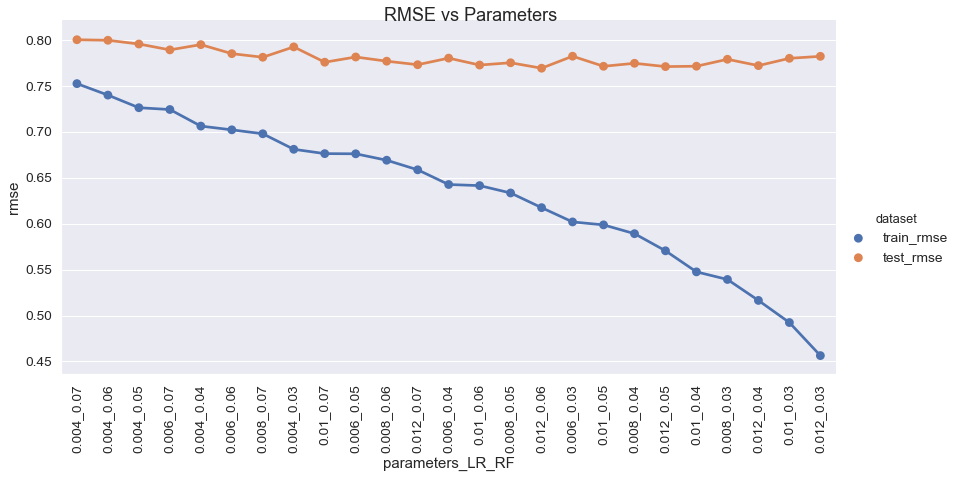

In [8]:
########################################################################
# plot the RMSE vs all the parameter combinations - to see which one gave the best RMSE
########################################################################

param_summ = param_summ.sort_values(by='train_rmse', ascending=False).reset_index(drop=True)
param_summ['LR'] = param_summ['learning_rate'].apply(str)
param_summ['RF'] = param_summ['reg_parm'].apply(str)
param_summ['parameters_LR_RF'] = param_summ[['LR', 'RF']].apply(lambda x: '_'.join(x), axis=1)
param_summ_plot = pd.melt(param_summ, id_vars=['parameters_LR_RF'], value_vars=['train_rmse', 'test_rmse'], \
                          var_name = 'dataset', value_name='rmse')

sns.set(font_scale=1.25)
lp = sns.catplot(x='parameters_LR_RF', y='rmse', hue='dataset', data=param_summ_plot, \
                 kind='point',height=6, aspect=12/6)
lp.fig.suptitle('RMSE vs Parameters')
lp.set_xticklabels(rotation=90)

We can see from the plot above that the RMSE on the test dataset doesn't improve much even though the RMSE of the training dataset goes low. The training dataset is getting overfitted with these parameters.

### II. Test the RMSE score from various algorithms

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Time to finish the rmse calculation : 2.63 mins


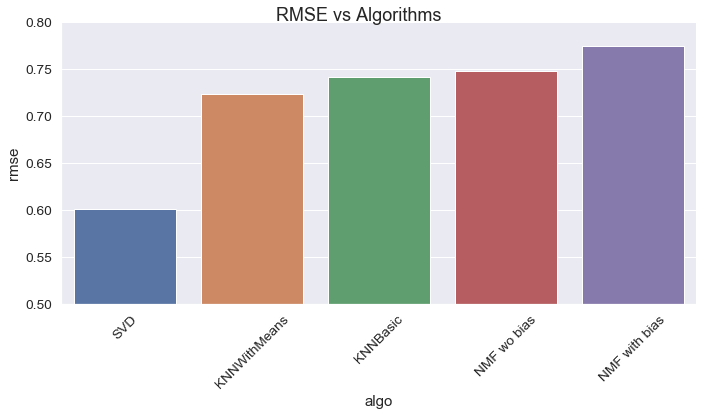

In [25]:
####################################
# Find the best possible result from various algos
# we will test the following algos - SVD, knnbasic, knnwithmeans, non negative matrix factorization (NMF)
####################################

st = time.time()

#define the rating scale for surprise reader and read the rating dataset 
rdr = Reader(rating_scale=(1,5))
rating_data = Dataset.load_from_df(ratings[['userId', 'itemId', 'rating']], rdr)

# sample random trainset and testset
# test set is made of 20% of the ratings.
trainset, testset = train_test_split(rating_data, test_size=.2, random_state=123)

data = [['SVD', 0],['KNNBasic', 0],['KNNWithMeans', 0],['NMF wo bias', 0],['NMF with bias', 0]]
param_summ = pd.DataFrame(data=data, columns=['algo', 'rmse'])

# SVD
algo = SVD()
predictions = algo.fit(trainset).test(test_temp)
rmse = accuracy.rmse(predictions, verbose=False)
param_summ.loc[0,['rmse']] = rmse

# knnbasic
algo = KNNBasic()
predictions = algo.fit(trainset).test(test_temp)
rmse = accuracy.rmse(predictions, verbose=False)
param_summ.loc[1,['rmse']] = rmse

# KNNWithMeans
algo = KNNWithMeans()
predictions = algo.fit(trainset).test(test_temp)
rmse = accuracy.rmse(predictions, verbose=False)
param_summ.loc[2,['rmse']] = rmse

# NMF wo bias
algo = NMF(biased=False)
predictions = algo.fit(trainset).test(test_temp)
rmse = accuracy.rmse(predictions, verbose=False)
param_summ.loc[3,['rmse']] = rmse

# NMF with bias
algo = NMF(biased=True)
predictions = algo.fit(trainset).test(test_temp)
rmse = accuracy.rmse(predictions, verbose=False)
param_summ.loc[4,['rmse']] = rmse

param_summ = param_summ.sort_values(by='rmse', ascending=True).reset_index(drop=True)

et = time.time()

print "Time to finish the rmse calculation :", round((et-st)/60, 2), "mins"

####################################
# Plot the RMSE from various algorithms to see which one gave the best preidction
####################################

sns.set(font_scale=1.25)
lp = sns.catplot(x='algo', y='rmse', data=param_summ, \
                 kind='bar',height=5, aspect=10/5)
lp.fig.suptitle('RMSE vs Algorithms')
lp.set_xticklabels(rotation=45)
lp.set(ylim=(0.5,0.8))

We can clearly see that the SVD algorithm performs best for prediction. We will use that for the large dataset to get the RMSE calculations.

### 3. Test the SVD on the large dataset and check the time taken for prediction

In [26]:
####################################
# import the large dataset
####################################

movies_20m = pd.read_csv('movie_20m.csv')
ratings_20m = pd.read_csv('rating_20m.csv')

# Get basic information about the datasets
print "Large dataset movies rows :", movies_20m.shape[0], " and ratings rows :",ratings_20m.shape[0]
print 'Unique movies in dataset : ', movies_20m['movieId'].nunique()
print 'Unique users in ratings data : ', ratings_20m['userId'].nunique()
print 'Unique movies in ratings data : ', ratings_20m['movieId'].nunique()

#reformat the rating dataset as per the surprise package requirement
ratings_20m = ratings_20m.rename(columns={'movieId':'itemId'})

Large dataset movies rows : 27278  and ratings rows : 20000263
Unique movies in dataset :  27278
Unique users in ratings data :  138493
Unique movies in ratings data :  26744


In [27]:
####################################
# fit the SVD algo on the large dataset and get the time for prediction
####################################

st = time.time()

#define the rating scale for surprise reader and read the rating dataset 
rdr = Reader(rating_scale=(1,5))
rating_data_20m = Dataset.load_from_df(ratings_20m[['userId', 'itemId', 'rating']], rdr)

# sample random trainset and testset - test set is made of 20% of the ratings.
trainset, testset = train_test_split(rating_data_20m, test_size=.2, random_state=123)

# fit the SVD algo on training and predict on test
algo = SVD()
predictions = algo.fit(trainset).test(testset)
rmse = accuracy.rmse(predictions, verbose=False)

et = time.time()

print "Total time taken for RMSE calculation of test dataset :", round((et-st)/60, 2), "mins"
print "RMSE on the test datset :", rmse

Total time taken for RMSE calculation of test dataset : 24.03 mins
RMSE on the test datset : 0.7860310300598353
